In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
import re

In [2]:
# choose and load dataset
dataset='z_center_p001'
npc=300
z=np.load('/oak/stanford/groups/mrivas/projects/degas-risk/datasets/train/tsvd/all_'+dataset+'_20190805_500PCs.npz')

# map phenotype names
with open('../../../ukbb-tools/05_gbe/icdinfo.txt', 'r') as i:
    code2phe={line.split()[0]:line.split()[2].replace('_',' ') for line in i}
# capitalize
code2phe={k:v[0].upper()+v[1:] for k,v in code2phe.items()}

# phenotype short names
def short(phe_name):
    repl={'(right)':'(R)', '(left)':'(L)', 
          'Human Cytomegalovirus':'HCMV',
          'covariate and statin adjusted':'(adj.)',
          'covariate adjusted':'(adj.)',
          'Intra-ocular pressure':'IOP', 
          'bone mineral density ':'', '(BMD)':'BMD',
          'quantitative ultrasound index ':'', '(QUI)':'QUI',
          'Number of self-reported':'Number of',
          ' (natural, before greying)':':',
          ' (chronotype)':'',
          ' (menarche)':'',
          ' (blood clot in lung)':'',
          'e only)':'s)',
          'Abdominal subcutaneous adipose tissue':'ASAT', ' (ASAT)':'',
          'platelet (thrombocyte)':'thrombocyte',
          'frequency.':'frequency',
          'Forced expiratory volume in 1-second ':'', '(FEV1)':'FEV1',
          'Volume of grey matter in Intracalcarine Cortex':'Intracalcarine cortical grey matter',
          'Heart attack/m':'M', ' (BMI)':'',
          ', automated reading':'',
          'reticulocyte percentage':'reticulocyte %'
         }
    return re.compile("|".join(map(re.escape, repl.keys()))).sub(lambda match: repl[match.group(0)], phe_name)

# choose phenotypes
phenos=['HC382']

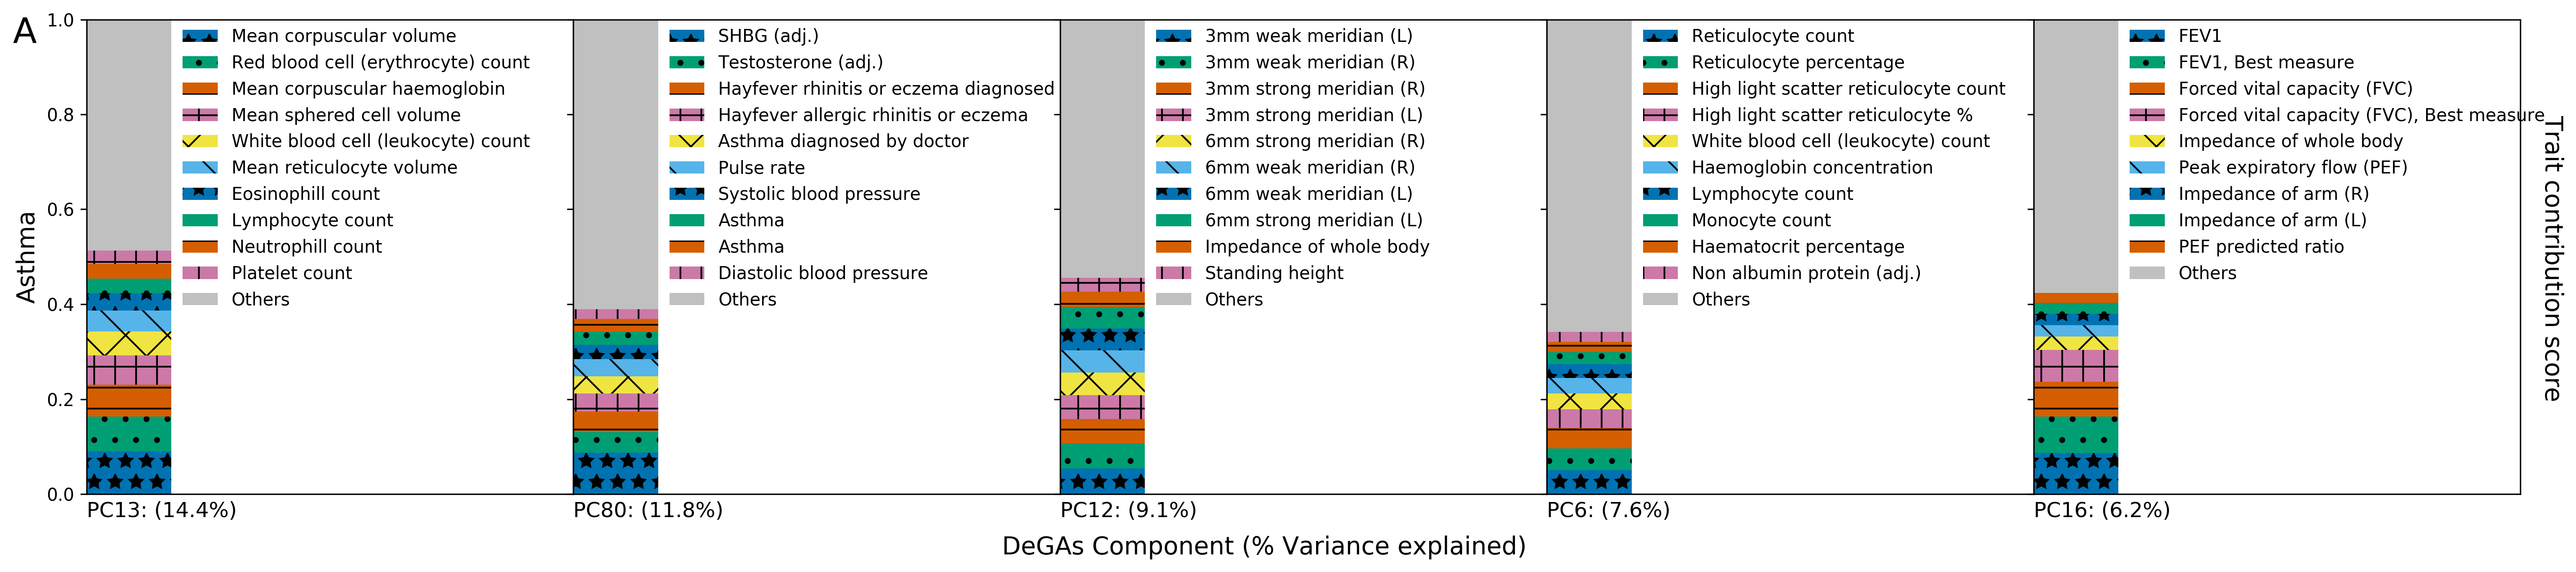

In [3]:
# adjust to use factor score VD rather than V (given W ~ UD(V^T))
V = z['V'] * z['D']

# setup for patterning within stacked barplot
patterns = ('-', '+', 'x', '\\', '*', '.')

# setup figure
k=5 # how many components
fudge=5
fs=14 # font size for outer label elements
plt.clf()
fig=plt.figure(figsize=(fudge*k, fudge*len(phenos)), dpi=300)

# loop over traits, top k components
for phx,phe in enumerate(phenos):
    pix=np.where(z['label_phe_code']==phe)
    for pcx in range(k):
        # setup: figure, which component, traits therein
        ax=fig.add_subplot(len(phenos), k, (k*phx)+pcx+1)
        pc=np.argsort(V[pix,:]**2).flatten()[-(pcx+1)]
        ranked_phes=np.argsort(V[:,pc]**2)[::-1].flatten()
        # loop over top 10 traits, plot bars if bar above 1%
        for ix,phe_ix in enumerate(ranked_phes[:10]):
            if (z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2) > 0.02:
                plt.bar([0], [(z['V'][phe_ix,pc]**2)/np.sum(z['V'][:,pc]**2)], 
                        bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2),
                        label=short(code2phe[z['label_phe_code'][phe_ix]]),
                        hatch=patterns[(ix + 4) % len(patterns) ]
                        )
            else: ix-=1; break
        ix+=1
        # add grey bar on top
        plt.bar([0], [1-(np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2))],
                bottom=np.sum(z['V'][ranked_phes[:ix],pc]**2)/np.sum(z['V'][:,pc]**2), 
                color='silver', label='Others')
        # adjust figure ticks/limits; add labels
        plt.ylim(0,1); plt.xlim(0,2.3)
        plt.xticks([],[])
        plt.xlabel('PC{0}: ({1:.1f}%)'.format(pc+1, 100*((V[pix,pc]**2)/np.sum(V[pix,:]**2))[0][0]), 
                   horizontalalignment='left', x=0.0, fontsize=fs-2)
        if pcx==0:
            plt.ylabel(short(code2phe[phe]), fontsize=fs)
            ax.text(-.35, 0.95, chr(65+phx), fontsize=20)
        else:
            ax.set_yticklabels(['' for _ in ax.get_yticks()])
        lgd=plt.legend(loc='upper left', bbox_to_anchor=(0.165, 1.015), frameon=False)

# add labels for the entire figure
fig.text(0.5, 0.04, 'DeGAs Component (% Variance explained)', ha='center', va='center', fontsize=fs)
fig.text(0.91, 0.5, 'Trait contribution score', ha='center', va='center', rotation=270, fontsize=fs)
fig.subplots_adjust(wspace=0, hspace=0.1)

# done
plt.show()
plt.savefig('fig3asthma.pdf', bbox_inches='tight')